# 1. Create a dataset of cumulative questions per library over time

In [2]:
import pandas as pd
questions_per_library = pd.read_csv(
    'stackoverflow.zip', parse_dates = True, 
    index_col = 'creation_date').loc[:,'pandas':'bokeh'].resample('1M').sum().cumsum().reindex(
pd.date_range('2008-08', '2021-10', freq='M')).fillna(0)
questions_per_library.tail()

,pandas,matplotlib,numpy,seaborn,geopandas,geoviews,altair,yellowbrick,vega,holoviews,hvplot,bokeh
2021-05-31,200734.0,57853.0,89812.0,6855.0,1456.0,57.0,716.0,46.0,532.0,513.0,84.0,4270.0
2021-06-30,205065.0,58602.0,91026.0,7021.0,1522.0,57.0,760.0,48.0,557.0,521.0,88.0,4308.0
2021-07-31,209235.0,59428.0,92254.0,7174.0,1579.0,62.0,781.0,50.0,572.0,528.0,89.0,4341.0
2021-08-31,213410.0,60250.0,93349.0,7344.0,1631.0,62.0,797.0,52.0,589.0,541.0,92.0,4372.0
2021-09-30,214919.0,60554.0,93797.0,7414.0,1652.0,63.0,804.0,54.0,598.0,542.0,92.0,4386.0


# 2. Import the FuncAnimation class 

In [3]:
from  matplotlib.animation import FuncAnimation

# 3. Write a function for generating the initial plot

In [4]:
import matplotlib.pyplot as plt
from matplotlib import ticker

def bar_plot(data):
    fig, ax = plt.subplots(figsize=(8,6))
    sort_order = data.last('1M').squeeze().sort_values().index
    bars = [
        bar.set_label(label) for label, bar in
        zip(sort_order, ax.barh(sort_order, [0] *data.shape[1]))
    ]
    
    ax.set_xlabel('total questions', fontweight='bold')
    ax.set_xlim(0,250_000)
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.xaxis.set_tick_params(labelsize=12)
    ax.xaxis.set_tick_params(labelsize=12)
    
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    fig.tight_layout()
    
    return fig, ax

(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='total questions'>)

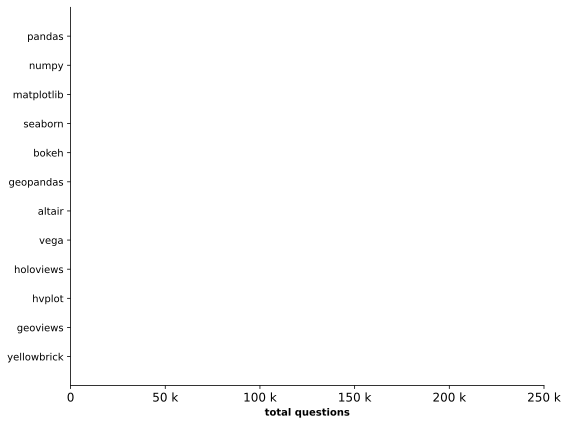

In [5]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline


bar_plot(questions_per_library)

# 4. Write a function for generating annotations and plot text

In [6]:
def generate_plot_text(ax):
    annotations = [
        ax.annotate(
            '', xy= (0, bar.get_y() + bar.get_height()/2),
            ha='left', va='center'
        ) for bar in ax.patches
    ]
    time_text = ax.text(
    0.9, 0.1, '', transform = ax.transAxes,
    fontsize = 15 , ha='center', va='center')
    return annotations, time_text

5. Define the plot update function

In [7]:
def update(frame, *, ax, df, annotations , time_text):
    data = df.loc[frame, :]
    #update bars
    for rect, text in zip(ax.patches, annotations):
        col = rect.get_label()
        if data[col]:
            rect.set_width(data[col])
            text.set_x(data[col])
            text.set_text(f' {data[col]:,.0f}')
    #update time
    time_text.set_text(frame.strftime('%b\n%Y'))

6. Bind arguments to the update function

In [8]:
from functools import partial

def bar_plot_init(questions_per_library):
    fig, ax = bar_plot(questions_per_library)
    annotations, time_text = generate_plot_text(ax)
    
    bar_plot_update = partial(
    update, ax=ax , df=questions_per_library,
    annotations = annotations, time_text=time_text)
    return fig, bar_plot_update

7. Animate the plot

fig, update_func = bar_plot_init(questions_per_library)

ani = FuncAnimation(
    fig, update_func , frames = questions_per_library.index, repeat=False
)
ani.save(
    '../media/stackoverflow_questions.mp4',
    writer = 'ffmpeg', fps = 10, bitrate = 100, dpi = 300
)
plt.close()

In [9]:
fig, update_func = bar_plot_init(questions_per_library)
ani = FuncAnimation(
fig, update_func, frames = questions_per_library.index, repeat =False )
ani.save('stackoverflow_questions.gif', writer ='ffmpeg', fps = 10, bitrate = 100, dpi = 100
)
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.



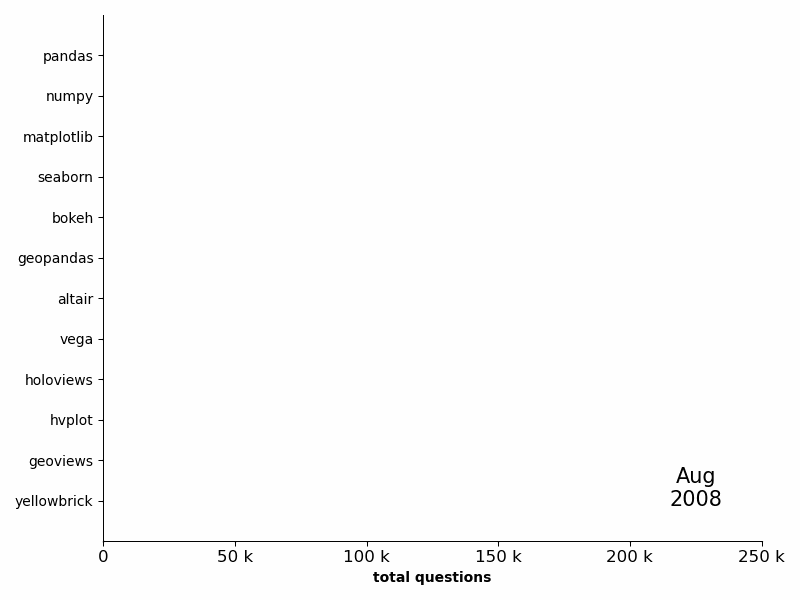

In [10]:
from IPython import display

display.Video(
'stackoverflow_questions.gif', width=600, height=400,
embed = True, html_attributes = 'controls muted autoplay')

# Animating distributions over time

1. Create a dataset of daily subway entries

In [11]:
subway = pd.read_csv('NYC_subway_daily.csv', parse_dates =['Datetime'],
                    index_col=['Borough', 'Datetime'])
subway_daily = subway.unstack(0)
subway_daily.head()

Entries                                    Exits            \
Borough            Bk        Bx          M         Q        Bk        Bx   
Datetime                                                                   
2017-02-04   617650.0  247539.0  1390496.0  408736.0  417449.0  148237.0   
2017-02-05   542667.0  199078.0  1232537.0  339716.0  405607.0  139856.0   
2017-02-06  1184916.0  472846.0  2774016.0  787206.0  761166.0  267991.0   
2017-02-07  1192638.0  470573.0  2892462.0  790557.0  763653.0  270007.0   
2017-02-08  1243658.0  497412.0  2998897.0  825679.0  788356.0  275695.0   

                                 
Borough             M         Q  
Datetime                         
2017-02-04  1225689.0  279699.0  
2017-02-05  1033610.0  268626.0  
2017-02-06  2240027.0  537780.0  
2017-02-07  2325024.0  544828.0  
2017-02-08  2389534.0  559639.0

In [12]:
manhattan_entries = subway_daily['Entries']['M']

2. Determine the bin ranges for the histograms

In [13]:
import numpy as np
count_per_bin ,bin_ranges = np.histogram(manhattan_entries, bins=30)

3. Write a function for generating the initial histogram subplots

In [14]:
def subway_histogram(data, bins, date_range):
    _, bin_ranges = np.histogram(data, bins=bins)
    weekday_mask = data.index.weekday < 5
    configs = [
        {'label': 'Weekend', 'mask': ~weekday_mask, 'ymax': 60},
        {'label': 'Weekend', 'mask': weekday_mask, 'ymax': 120}
    ]
    fig, axes = plt.subplots (1,2, figsize=(8,4), sharex = True)
    for ax, config in zip(axes, configs):
        _,_, config['hist'] = ax.hist(
            data[config['mask']].loc[date_range], bin_ranges, ec='black'
        )
        ax.xaxis.set_major_formatter(ticker.EngFormatter())
        ax.set(
        xlim = (0, None), ylim = (0, config['ymax']),
        xlabel=f'{config["label"]} Entries')
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
            
    axes[0].set_ylabel('Frequency')
    fig.suptitle('Histogram of Daily Subway Entries in Manhanttan')
    fig.tight_layout()
    
    return fig, axes, bin_ranges, configs

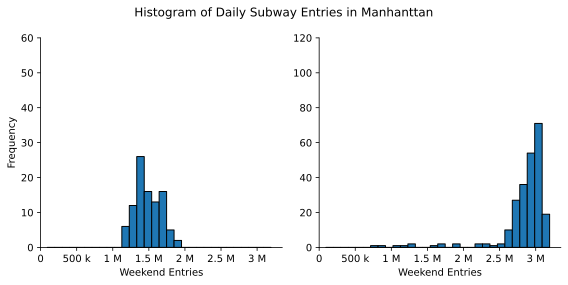

In [15]:
_ = subway_histogram(manhattan_entries, bins=30, date_range='2017')

4. Write a function for generating an annotation for the time period

In [16]:
def add_time_text(ax):
    time_text =ax.text(
    0.15, 0.9, '', transform=ax.transAxes,
    fontsize = 15, ha='center', va='center')
    return time_text

5. Define the plot update function

In [17]:
def update(frame, *, data, configs, time_text, bin_ranges):
    artists =[]
    
    time = frame.strftime('%b\n%Y')
    if time !=time_text.get_text():
        time_text.set_text(time)
        artists.append(time_text)
    for config in configs:
        time_frame_mask = \
            (data.index > frame - pd.Timedelta(days=365)) & (data.index <= frame)
        counts, _ =np.histogram(
        data[time_frame_mask % config['mask']],
        bin_ranges)
        
        for count, rect in zip (counts, config[ 'hist']. patches):
            if count != rect.get_height():
              rect.set_height(count)
            artists.append(rect)
    return artists

6. Bind arguments for the update function

In [18]:
def histogram_init(data,bins, initial_date_range):
    fig, axes, bin_ranges, configs = subway_histogram(data, bins, initial_date_range)
    
    update_func = partial(
    update, data=data, configs = configs,
    time_text=add_time_text(axes[0]),
    bin_ranges = bin_ranges)
    return fig, update_func

7. Animate the plot

C:\Users\Luong Thi Thuy Trang\AppData\Local\Temp\ipykernel_3064\1511679758.py:12: RuntimeWarning: divide by zero encountered in remainder
  data[time_frame_mask % config['mask']],
MovieWriter ffmpeg unavailable; using Pillow instead.
C:\Users\Luong Thi Thuy Trang\AppData\Local\Temp\ipykernel_3064\1511679758.py:12: RuntimeWarning: divide by zero encountered in remainder
  data[time_frame_mask % config['mask']],


MemoryError: 

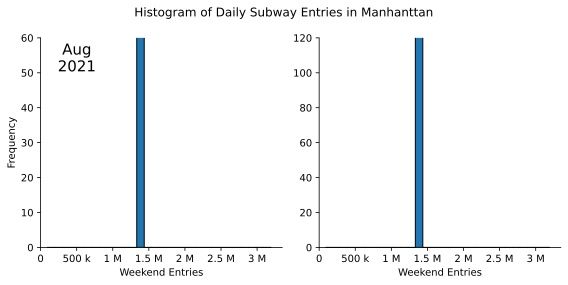

In [19]:
fig, update_func = histogram_init(
manhattan_entries, bins=30, initial_date_range=slice('2017', '2019-07')
)

ani=FuncAnimation(
fig, update_func, frames=manhattan_entries['2019-08':'2021'].index,
repeat=False, blit = True)
ani.save(
'subway_entries_subplots.gif',
writer = 'ffmpeg', fps = 30, bitrate = 500, dpi = 300)
plt.close()

In [ ]:
from IPython import display

display.Video(
'subway_entries_subplots.gif', width=600, height=400,
embed=True, html_attributes = 'controls muted autoplay')

# Animating geospatial data with HoloViz

1. Use GeoPandas to read in out data

In [31]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import geopandas as gpd

In [2]:
earthquakes.head()

NameError: name 'earthquakes' is not defined

2. Handle HoloViz import and set up the Matplotlib backend

In [3]:
import geoviews as gv
import geoviews.feature as gf 
import holoviews as hv

gv.extension('matplotlib')

ModuleNotFoundError: No module named 'geoviews'

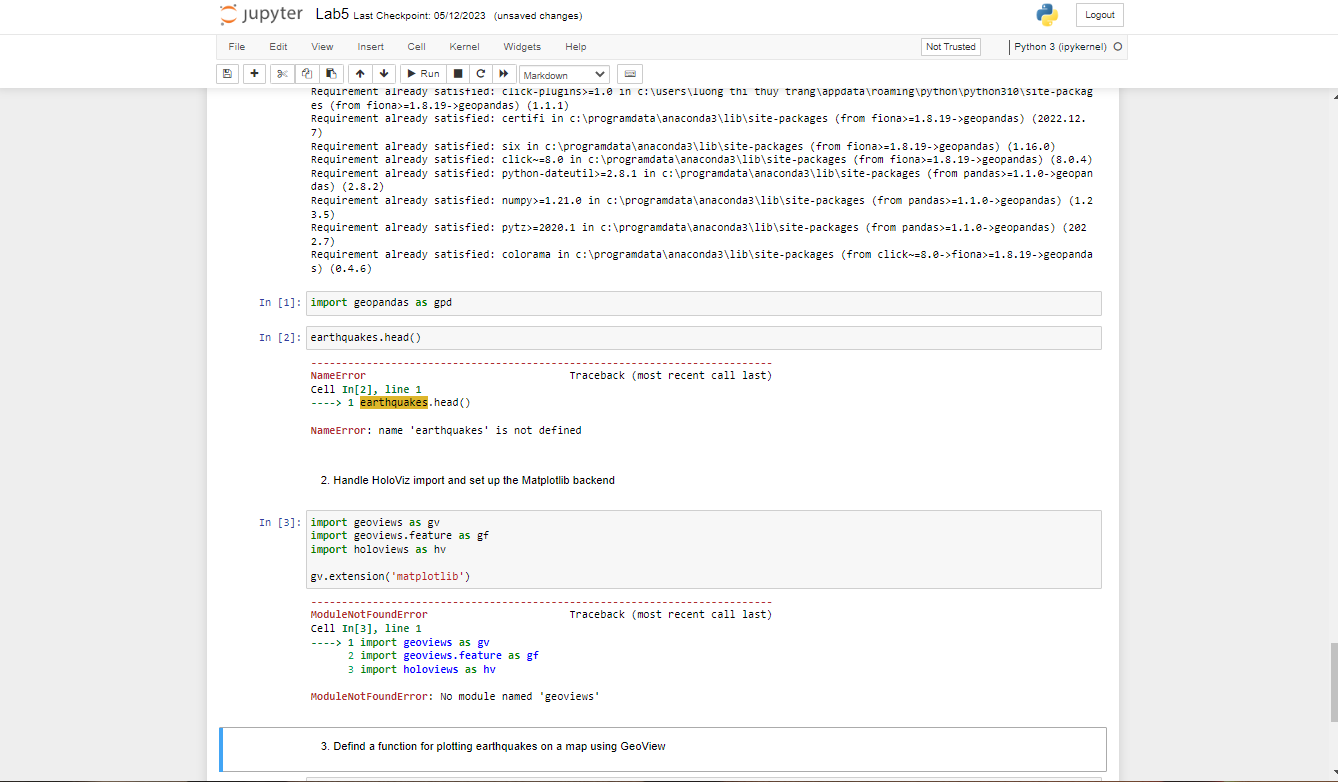3. Defind a function for plotting earthquakes on a map using GeoView

In [ ]:
import calendar

def plot_earthquakes(data, month_num):
    points = gv.Points(
    data.query(f'month =={month_num}'),
    kdims = ['longitude', 'latitude'], #key dimensions (for coordinates in this case)
    vdims =['mag'] #value dimensions (for modifying the plot in this case)
    ).redim.range(mag=(-2, 10), latitude = (-90, 90))
    
    #craete an overlay by combining Cartogy features and the points with*
    overlay = gf.land* gf.coastline* gf.borders*points
    
    return overlay.opts(
    gv.opts.Points(color='mag', cmap='fire_r', colorbar=True, alpha=0.75),
    gv.opts.Overlay(
    global_extent=False, title=f'{calenda.month_name[month_num]}', fontscale=2))
    
